<a href="https://colab.research.google.com/github/SUPAGORN0306/229352-StatisticalLearning/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repo from github

In [ ]:
!git clone https://github.com/Tassathorn/data_for_the_workshop_at_CMU.git

fatal: destination path 'data_for_the_workshop_at_CMU' already exists and is not an empty directory.


# Import library

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dropout, Dense, Activation
from keras.optimizers import Adam
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")


import os
import random
import numpy as np
import tensorflow as tf

SEED = 0

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Prepare input data

In [2]:
df = pd.read_csv("/content/Electricity quantity.csv")
df.dropna(inplace=True)

df.index = pd.date_range(start="2014-01", periods=len(df), freq="MS")
df.head()

,date,y
2014-01-01,1/1/2014,52548712.45
2014-02-01,2/1/2014,52977763.18
2014-03-01,3/1/2014,62610108.35
2014-04-01,4/1/2014,58400221.28
2014-05-01,5/1/2014,65722728.55


In [3]:
percent_test = 0.1
predict_column = 'y'

n = len(df)
test = int(n*percent_test)
train = n-test
sum_data = train+test

print(f'-------------------- Input --------------------')
print(f'Total: {sum_data}')
print(f'Train: {train}')
print(f'Test: {test}')

-------------------- Input --------------------
Total: 126
Train: 114
Test: 12


In [4]:
print(df.columns)

Index(['date', 'y'], dtype='object')


In [5]:
plot_df = pd.DataFrame({
    "index": df.index,
    "value": df[predict_column],
    "set": ["train"] * train + ["test"] * (len(df) - train)
})

fig = px.line(
    plot_df,
    x="index",
    y="value",
    color="set",
    title="Train / Test split",
    labels={
        "index": "Data Point",
        "value": "Price",
        "set": "Dataset"
    }
)

fig.show()

# LSTM

### Normalize

In [ ]:
data_lstm = pd.DataFrame()
data_lstm[predict_column] = df[predict_column].copy()

scaler_lstm = MinMaxScaler(feature_range=(0,1))
scaled_lstm = scaler_lstm.fit_transform(data_lstm)
scaled_lstm[:5]

array([[0.08202993],
       [0.09949842],
       [0.49167243],
       [0.3202699 ],
       [0.61840052]])

### Create training data

In [ ]:
x_train_lstm, y_train_lstm = [], []
lookback = 4

for i in range(lookback, train+1):
    x_train_lstm.append(scaled_lstm[i-lookback:i, 0])
    y_train_lstm.append(scaled_lstm[i, 0])

x_train_lstm = np.array(x_train_lstm)
y_train_lstm = np.array(y_train_lstm)

# reshape -> 3D for LSTM: (samples, timesteps, features)
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

x_train_lstm.shape, y_train_lstm.shape

((111, 4, 1), (111,))

In [ ]:
x_train_lstm[:5]

array([[[0.08202993],
        [0.09949842],
        [0.49167243],
        [0.3202699 ]],

       [[0.09949842],
        [0.49167243],
        [0.3202699 ],
        [0.61840052]],

       [[0.49167243],
        [0.3202699 ],
        [0.61840052],
        [0.51578225]],

       [[0.3202699 ],
        [0.61840052],
        [0.51578225],
        [0.55976864]],

       [[0.61840052],
        [0.51578225],
        [0.55976864],
        [0.57186525]]])

In [ ]:
y_train_lstm[:5]

array([0.61840052, 0.51578225, 0.55976864, 0.57186525, 0.51755889])

### Build LSTM model

In [ ]:
round_epochs = 100

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape=(x_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1)) #output node

lr = 0.01  # ลองเปลี่ยนค่าได้
optimizer = Adam(learning_rate=lr)

lstm_model.compile(optimizer=optimizer, loss="mean_squared_error")

print('-------------------- Train Model (LSTM) --------------------')
history1 = lstm_model.fit(x_train_lstm, y_train_lstm, batch_size=32, epochs=round_epochs, validation_split=0.1, verbose=1)

print('-------------------- Summary (LSTM) --------------------')
lstm_model.summary()

-------------------- Train Model (LSTM) --------------------
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.2887 - val_loss: 0.1101
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0639 - val_loss: 0.0606
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0780 - val_loss: 0.0437
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0477 - val_loss: 0.0760
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0522 - val_loss: 0.0445
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0428 - val_loss: 0.0401
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0472 - val_loss: 0.0419
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0434 - val_loss: 0.0488
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0433 - val_loss: 0.0416
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0404 - val_loss: 0.0386
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0405 - val_loss: 0.0400
Epoch 12/100

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

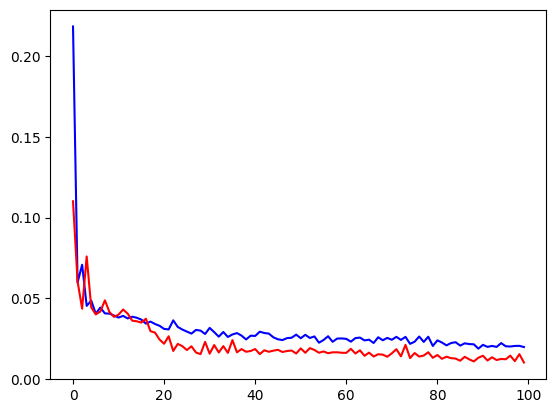

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history["loss"], color='blue')#สีฟ้าคือ training loss
plt.plot(history1.history["val_loss"], color='red')
# plt.title("Training Loss")

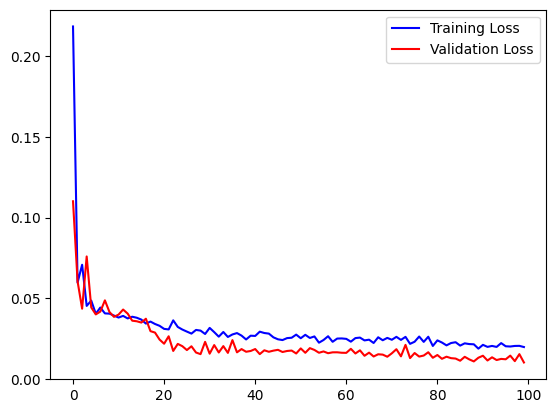

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history1.history["loss"], color='blue', label='Training Loss')
plt.plot(history1.history["val_loss"], color='red', label='Validation Loss')

# เพิ่มรายละเอียด
# plt.title("Model Loss Over Epochs")       # ชื่อกราฟ
# plt.xlabel("Epoch")                       # แกน X
# plt.ylabel("Loss")                        # แกน Y
plt.legend(loc="upper right")             # คำอธิบายเส้น
# plt.grid(True)                            # เส้นตารางช่วยอ่านค่า

plt.show()


In [ ]:
print("Training Loss:", history1.history['loss'])
print("Validation Loss:", history1.history['val_loss'])

Training Loss: [0.2182895839214325, 0.05979312211275101, 0.07084698975086212, 0.045377980917692184, 0.04864758998155594, 0.040532756596803665, 0.044380612671375275, 0.04074981063604355, 0.04059849679470062, 0.039396800100803375, 0.03817054629325867, 0.03920263797044754, 0.03762790560722351, 0.038679033517837524, 0.03805643320083618, 0.036906898021698, 0.03444470837712288, 0.03568323329091072, 0.03419683873653412, 0.03306543827056885, 0.03116331622004509, 0.030825970694422722, 0.03644658997654915, 0.03236045688390732, 0.030753381550312042, 0.0294805821031332, 0.028243238106369972, 0.03051437810063362, 0.030102282762527466, 0.028007986024022102, 0.031771302223205566, 0.029150288552045822, 0.026356754824519157, 0.0292371716350317, 0.026165880262851715, 0.027718637138605118, 0.02856760285794735, 0.027000200003385544, 0.024617254734039307, 0.026951994746923447, 0.026794781908392906, 0.029432063922286034, 0.028611037880182266, 0.028237024322152138, 0.025929318740963936, 0.024712957441806793,

 overfitting bc line trainning loss above line testing loss -> model complex  

### Create test data

In [ ]:
inputs_lstm = data_lstm[len(data_lstm)-test-lookback:].values
inputs_lstm = inputs_lstm.reshape(-1,1)
inputs_lstm = scaler_lstm.transform(inputs_lstm)

X_test_lstm = []
for i in range(lookback, inputs_lstm.shape[0]):
    X_test_lstm.append(inputs_lstm[i-lookback:i, 0])

X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

X_test_lstm.shape

(12, 4, 1)

In [ ]:
X_test_lstm[:5]

array([[[0.47311368],
        [0.24423584],
        [0.62417545],
        [0.57722918]],

       [[0.24423584],
        [0.62417545],
        [0.57722918],
        [0.6191181 ]],

       [[0.62417545],
        [0.57722918],
        [0.6191181 ],
        [0.67855194]],

       [[0.57722918],
        [0.6191181 ],
        [0.67855194],
        [0.51298079]],

       [[0.6191181 ],
        [0.67855194],
        [0.51298079],
        [0.51514869]]])

### Prediction

In [ ]:
# predict_value_LSTM = lstm_model.predict(X_test_lstm, verbose=0)
# predict_value_LSTM = scaler_lstm.inverse_transform(predict_value_LSTM)

# predict_LSTM_df = pd.DataFrame(
#     predict_value_LSTM,
#     index=list(range(train, len(data_lstm))),
#     columns=["predict_value"]
# )

# predict_LSTM_df.head()

In [ ]:
predict_value_LSTM = lstm_model.predict(X_test_lstm, verbose=0)
predict_value_LSTM = scaler_lstm.inverse_transform(predict_value_LSTM)

# ใช้ index จริงของ data_lstm ช่วง test
pred_index = data_lstm.index[train:len(data_lstm)]

predict_LSTM_df = pd.DataFrame(
    predict_value_LSTM,
    index=pred_index,
    columns=["predict_value"]
)

predict_LSTM_df.head()

,predict_value
2023-07-01,69876440.0
2023-08-01,68139504.0
2023-09-01,64017320.0
2023-10-01,63574032.0
2023-11-01,60228972.0


In [ ]:
predict_LSTM_df.shape

(12, 1)

### Visualize

In [ ]:
plot_df = pd.DataFrame({
    "index": data_lstm.index,
    "Actual": data_lstm[predict_column],
})

plot_df = plot_df.merge(
    predict_LSTM_df.rename(columns={"predict_value": "Prediction"}),
    left_on="index",
    right_index=True,
    how="left"
)

plot_long = plot_df.melt(
    id_vars="index",
    value_vars=["Actual", "Prediction"],
    var_name="Series",
    value_name="Value"
)

fig = px.line(
    plot_long,
    x="index",
    y="Value",
    color="Series",
    title="LSTM",
    labels={
        "index": "Date",
        "Value": "Electricity Consumption",
        "Series": ""
    }
)
fig.show()

### Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error

print('-------------------- RESULT (LSTM) --------------------')
print(f"MAPE: {round(mean_absolute_percentage_error(data_lstm[train:], predict_LSTM_df) * 100, 4)} %")
print(f"RMSE: {round(np.sqrt(mean_squared_error(data_lstm[train:], predict_LSTM_df)), 4)}")
print(f"MAE:  {round(mean_absolute_error(data_lstm[train:], predict_LSTM_df), 4)}")

-------------------- RESULT (LSTM) --------------------
MAPE: 2.8518 %
RMSE: 2511943.655
MAE:  1754655.2125


In [ ]:
def calc_metrics(y_true, y_pred):
    return {
        "MAPE(%)": mean_absolute_percentage_error(y_true, y_pred) * 100,
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

rows = []
for col in ["LSTM"]:
    if col == "LSTM":
      m = calc_metrics(data_lstm[train:], predict_LSTM_df)
    m["Model"] = col
    rows.append(m)

metric_df = pd.DataFrame(rows).set_index("Model")
metric_df = metric_df.round({"MAPE(%)": 4, "RMSE": 4, "MAE": 4})

metric_df

,MAPE(%),RMSE,MAE
Model,,,
LSTM,2.8518,2511943.655,1.754655e+06
